In [1]:
import scanpy as sc
import cfp
import os
import anndata as ad
import pandas as pd
import numpy as np
import rapids_singlecell as rsc
import pickle
from cfp.preprocessing import transfer_labels, compute_wknn, centered_pca, project_pca

/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/optuna/study/_optimize.py:29: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from optuna import progress_bar as pbar_module


In [2]:
out_dir = "/lustre/groups/ml01/workspace/ot_perturbation/figures/pbmc_new_cytokine/umaps"

In [3]:
df_id = pd.read_csv("/lustre/groups/ml01/workspace/ot_perturbation/models/identity/pbmc_new_cytokine/metrics_new_cytokine.csv", index_col=0)

In [4]:
adata_full = sc.read_h5ad("/lustre/groups/ml01/workspace/ot_perturbation/data/pbmc/pbmc_with_pca.h5ad")

with open("/lustre/groups/ml01/workspace/ot_perturbation/data/pbmc/idcs_to_keep.pkl", "rb") as pickle_file:
    idcs_to_keep = pickle.load(pickle_file)
adata_ref = adata_full[adata_full.obs_names.isin(idcs_to_keep)]


In [5]:
df_id[(df_id["donor"]=="Donor1")&(df_id["cytokine"]=="IL-15")][['e_distance_CD14 Mono', "mean_decoded_r_sq_per_cell_type", "mean_deg_r_sq_per_cell_type", "decoded_ood_r_squared"]]

e_distance_CD14 Mono  mean_decoded_r_sq_per_cell_type  \
Donor1_IL-15            235.993406                         0.862117   

              mean_deg_r_sq_per_cell_type  decoded_ood_r_squared  
Donor1_IL-15                     0.318808               0.914834

In [6]:
df_cf = pd.read_csv("/lustre/groups/ml01/workspace/ot_perturbation/data/pbmc/metrics/metrics_new_cytokine.csv", index_col=0)

In [7]:
df_cf.head()

mean_decoded_r_sq_per_cell_type  \
Donor4_C5a                             0.955791   
Donor7_OX40L                           0.922924   
Donor10_C5a                            0.948272   
Donor11_4-1BBL                         0.931346   
Donor6_OSM                             0.955859   

                mean_e_distance_per_cell_type  mean_mmd_per_cell_type  \
Donor4_C5a                          11.660839                0.008871   
Donor7_OX40L                        35.460599                0.013862   
Donor10_C5a                         16.919249                0.010235   
Donor11_4-1BBL                      22.054480                0.014290   
Donor6_OSM                          13.854135                0.007579   

                mean_sdiv_10_per_cell_type  mean_sdiv_100_per_cell_type  \
Donor4_C5a                       90.671855                    12.128944   
Donor7_OX40L                    111.972876                    25.847652   
Donor10_C5a                      97.359693                    15.502340   
Donor11_4-1BBL                  102.952084                    17.665734   
Donor6_OSM                       96.074269                    13.403070   

                mean_deg_r_sq_per_cell_type  \
Donor4_C5a                         0.873296   
Donor7_OX40L                       0.765109   
Donor10_C5a                        0.816124   
Donor11_4-1BBL                     0.813616   
Donor6_OSM                         0.880971   

                mean_deg_e_distance_per_cell_type  mean_deg_mmd_per_cell_type  \
Donor4_C5a                              17.662023                    0.040608   
Donor7_OX40L                            35.802167                    0.046710   
Donor10_C5a                             25.159851                    0.041936   
Donor11_4-1BBL                          24.228663                    0.046342   
Donor6_OSM                              18.501366                    0.038873   

                mean_deg_sdiv_10_per_cell_type  \
Donor4_C5a                          125.486287   
Donor7_OX40L                        147.587429   
Donor10_C5a                         139.200932   
Donor11_4-1BBL                      151.745742   
Donor6_OSM                          129.942240   

                mean_deg_sdiv_100_per_cell_type  ...  div_10_pDC  div_100_pDC  \
Donor4_C5a                            17.470218  ...         NaN          NaN   
Donor7_OX40L                          29.255601  ...         NaN          NaN   
Donor10_C5a                           21.871986  ...         NaN          NaN   
Donor11_4-1BBL                        23.805972  ...         NaN          NaN   
Donor6_OSM                            16.470612  ...         NaN          NaN   

                deg_decoded_r_squared_pDC  deg_e_distance_pDC  deg_mmd_pDC  \
Donor4_C5a                            NaN                 NaN          NaN   
Donor7_OX40L                          NaN                 NaN          NaN   
Donor10_C5a                           NaN                 NaN          NaN   
Donor11_4-1BBL                        NaN                 NaN          NaN   
Donor6_OSM                            NaN                 NaN          NaN   

                deg_div_10_pDC  deg_div_100_pDC  donor_cytokine    donor  \
Donor4_C5a                 NaN              NaN      Donor4_C5a   Donor4   
Donor7_OX40L               NaN              NaN    Donor7_OX40L   Donor7   
Donor10_C5a                NaN              NaN     Donor10_C5a  Donor10   
Donor11_4-1BBL             NaN              NaN  Donor11_4-1BBL  Donor11   
Donor6_OSM                 NaN              NaN      Donor6_OSM   Donor6   

                cytokine  
Donor4_C5a           C5a  
Donor7_OX40L       OX40L  
Donor10_C5a          C5a  
Donor11_4-1BBL    4-1BBL  
Donor6_OSM           OSM  

[5 rows x 172 columns]

In [8]:
res = {}
for cyto in df_cf["cytokine"].unique():
    df_tmp = df_cf[(df_cf["donor"]=="Donor1")&(df_cf["cytokine"]==cyto)]
    diff = df_tmp[df_tmp.num_donors_in_train==1.0]["decoded_ood_r_squared"].values[0]-df_tmp[df_tmp.num_donors_in_train==0.0]["decoded_ood_r_squared"].values[0]
    res[cyto]=diff

In [9]:
df_cf.loc["Donor1_IL-15"][['e_distance_CD14 Mono', "mean_decoded_r_sq_per_cell_type", "mean_deg_r_sq_per_cell_type", "decoded_ood_r_squared", "num_donors_in_train", "wandb_name"]]

e_distance_CD14 Mono  mean_decoded_r_sq_per_cell_type  \
Donor1_IL-15             21.361391                         0.881831   
Donor1_IL-15             27.519961                         0.878033   
Donor1_IL-15             24.539120                         0.882992   
Donor1_IL-15             32.284683                         0.883001   
Donor1_IL-15             27.789974                         0.876308   
Donor1_IL-15             13.360500                         0.881739   
Donor1_IL-15             35.942360                         0.878513   
Donor1_IL-15             29.737569                         0.883093   
Donor1_IL-15             24.916274                         0.883968   
Donor1_IL-15             18.851502                         0.885515   
Donor1_IL-15             33.500459                         0.882295   
Donor1_IL-15             22.887689                         0.883596   
Donor1_IL-15             45.601878                         0.881643   
Donor1_IL-15             22.230056                         0.884490   
Donor1_IL-15             18.046912                         0.884819   
Donor1_IL-15             23.834071                         0.880504   
Donor1_IL-15             28.076472                         0.884870   
Donor1_IL-15            253.355632                         0.831374   
Donor1_IL-15             19.625041                         0.885627   
Donor1_IL-15             31.158884                         0.878520   
Donor1_IL-15             32.284683                         0.883001   

              mean_deg_r_sq_per_cell_type  decoded_ood_r_squared  \
Donor1_IL-15                     0.606059               0.979482   
Donor1_IL-15                     0.572779               0.979691   
Donor1_IL-15                     0.582217               0.977041   
Donor1_IL-15                     0.584627               0.982803   
Donor1_IL-15                     0.561142               0.978581   
Donor1_IL-15                     0.598295               0.980297   
Donor1_IL-15                     0.563464               0.973675   
Donor1_IL-15                     0.595743               0.983012   
Donor1_IL-15                     0.614009               0.980976   
Donor1_IL-15                     0.608440               0.981646   
Donor1_IL-15                     0.580125               0.977381   
Donor1_IL-15                     0.594618               0.979765   
Donor1_IL-15                     0.577461               0.978229   
Donor1_IL-15                     0.609838               0.984786   
Donor1_IL-15                     0.610833               0.980778   
Donor1_IL-15                     0.573171               0.980086   
Donor1_IL-15                     0.595492               0.982142   
Donor1_IL-15                     0.230055               0.905004   
Donor1_IL-15                     0.606813               0.981922   
Donor1_IL-15                     0.570652               0.979677   
Donor1_IL-15                     0.584627               0.982803   

              num_donors_in_train             wandb_name  
Donor1_IL-15                  7.0     bumbling-sound-568  
Donor1_IL-15                  2.0    rural-armadillo-553  
Donor1_IL-15                  3.0        worthy-frog-555  
Donor1_IL-15                  1.0     flowing-shadow-548  
Donor1_IL-15                  2.0       glowing-dawn-552  
Donor1_IL-15                  7.0         clean-tree-566  
Donor1_IL-15                  3.0         balmy-snow-556  
Donor1_IL-15                  8.0        young-gorge-572  
Donor1_IL-15                  9.0      hearty-vortex-573  
Donor1_IL-15                 11.0    likely-mountain-580  
Donor1_IL-15                  4.0           sage-fog-559  
Donor1_IL-15                  8.0       smart-forest-570  
Donor1_IL-15                  5.0       misty-shadow-561  
Donor1_IL-15                  6.0      young-glitter-563  
Donor1_IL-15                  3.0        skilled-bee-554  
Donor1_IL-

In [10]:
donor = "Donor1"
cytokine = "IL-15"


In [11]:
condition = f"{donor}_{cytokine}"
wandb_name = "effortless-cosmos-547"
num_donors_in_train = 0
condition = condition + "_" + str(num_donors_in_train)
adata_pred_0 = sc.read_h5ad(os.path.join("/lustre/groups/ml01/workspace/ot_perturbation/models/otfm/pbmc_new_cytokine", f"{wandb_name}_{condition}_preds.h5ad"))


In [12]:
condition = f"{donor}_{cytokine}"
wandb_name = "flowing-shadow-548"
num_donors_in_train = 1
condition = condition + "_" + str(num_donors_in_train)
adata_pred_1 = sc.read_h5ad(os.path.join("/lustre/groups/ml01/workspace/ot_perturbation/models/otfm/pbmc_new_cytokine", f"{wandb_name}_{condition}_preds.h5ad"))


In [13]:
#condition = f"{donor}_{cytokine}"
#wandb_name = "likely-mountain-580"
#num_donors_in_train = 11
#condition = condition + "_" + str(num_donors_in_train)
#adata_pred_11 = sc.read_h5ad(os.path.join("/lustre/groups/ml01/workspace/ot_perturbation/models/otfm/pbmc_new_cytokine", f"{wandb_name}_{condition}_preds.h5ad"))


In [14]:
adata_pred_0.X = adata_pred_0.layers["X_recon"]
adata_pred_0.obs["cytokine"] = cytokine
adata_pred_0.obs["donor"] = donor
adata_pred_0.var_names=adata_full.var_names
adata_pred_0.obs["mode"]="pred_0"
project_pca(query_adata=adata_pred_0, ref_adata=adata_ref, obsm_key_added="X_pca_for_ct_transfer")
compute_wknn(ref_adata=adata_ref, query_adata=adata_pred_0, n_neighbors=1, ref_rep_key="X_pca", query_rep_key="X_pca_for_ct_transfer")
transfer_labels(query_adata=adata_pred_0, ref_adata=adata_ref, label_key="cell_type_new")
adata_pred_0.obs["cell_type_new"] = adata_pred_0.obs["cell_type_new_transfer"]
    

adata_pred_1.X = adata_pred_1.layers["X_recon"]
adata_pred_1.obs["cytokine"] = cytokine
adata_pred_1.obs["donor"] = donor
adata_pred_1.var_names=adata_full.var_names
adata_pred_1.obs["mode"]="pred_1"
project_pca(query_adata=adata_pred_1, ref_adata=adata_ref, obsm_key_added="X_pca_for_ct_transfer")
compute_wknn(ref_adata=adata_ref, query_adata=adata_pred_1, n_neighbors=1, ref_rep_key="X_pca", query_rep_key="X_pca_for_ct_transfer")
transfer_labels(query_adata=adata_pred_1, ref_adata=adata_ref, label_key="cell_type_new")
adata_pred_1.obs["cell_type_new"] = adata_pred_1.obs["cell_type_new_transfer"]

#adata_pred_11.X = adata_pred_11.layers["X_recon"]
#adata_pred_11.obs["cytokine"] = cytokine
#adata_pred_11.obs["donor"] = donor
#adata_pred_11.var_names=adata_full.var_names
#adata_pred_11.obs["mode"]="pred_11"
#project_pca(query_adata=adata_pred_11, ref_adata=adata_ref, obsm_key_added="X_pca_for_ct_transfer")
#compute_wknn(ref_adata=adata_ref, query_adata=adata_pred_11, n_neighbors=1, ref_rep_key="X_pca", query_rep_key="X_pca_for_ct_transfer")
#transfer_labels(query_adata=adata_pred_11, ref_adata=adata_ref, label_key="cell_type_new")
#adata_pred_11.obs["cell_type_new"] = adata_pred_1.obs["cell_type_new_transfer"]

    


/ictstr01/home/icb/dominik.klein/git_repos/cell_flow_perturbation/src/cfp/preprocessing/_wknn.py:84: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  ref_adata.uns[uns_key_added] = wknn


In [15]:
adata_pred_0.obs["cell_type_new"] = adata_pred_0.obs["cell_type_new_transfer"]
adata_pred_1.obs["cell_type_new"] = adata_pred_1.obs["cell_type_new_transfer"]
#adata_pred_11.obs["cell_type_new"] = adata_pred_11.obs["cell_type_new_transfer"]

In [16]:
adata_ood_true = adata_full[(adata_full.obs["donor"] == donor) & (adata_full.obs["cytokine"]==cytokine)]    
adata_ood_true.obs["mode"] = "true"
adata_ctrl = adata_full[(adata_full.obs["cytokine"]=="PBS")&(adata_full.obs["donor"]==donor)]
adata_ctrl.obs["mode"] = "control"
    

/tmp/ipykernel_458782/3560315137.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_ood_true.obs["mode"] = "true"
/tmp/ipykernel_458782/3560315137.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_ctrl.obs["mode"] = "control"


In [17]:
to_subsample=min(adata_ood_true.n_obs, 10_000)
#sc.pp.subsample(adata_pred_0,n_obs=to_subsample)
#sc.pp.subsample(adata_pred_1,n_obs=to_subsample)
#sc.pp.subsample(adata_pred_11,n_obs=to_subsample)
#sc.pp.subsample(adata_ctrl,n_obs=to_subsample)

In [18]:
#bdata = ad.concat((adata_pred_0, adata_pred_1, adata_pred_11, adata_ood_true, adata_ctrl))
bdata = ad.concat((adata_pred_0, adata_pred_1, adata_ood_true, adata_ctrl))

/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [19]:
bdata

AnnData object with n_obs × n_vars = 120315 × 2000
    obs: 'condition', 'cytokine', 'donor', 'mode', 'cell_type_new'
    obsm: 'X_pca'

In [20]:
rsc.pp.pca(bdata)

In [21]:
rsc.pp.neighbors(bdata)

In [22]:
sc.tl.umap(bdata)

In [23]:
bdata.obs = bdata.obs.reset_index()

/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/anndata/_core/anndata.py:1209: Imp

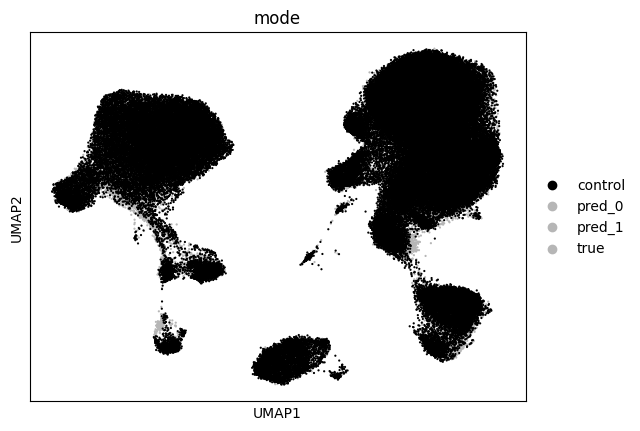

In [24]:
palette = {"control": "#000000", "true": "#B6B6B6", "pred_0": "#B6B6B6", "pred_1": "#B6B6B6"}
order =  list(bdata[bdata.obs["mode"]=="pred_0"].obs_names) + list(bdata[bdata.obs["mode"]=="pred_1"].obs_names) + list(bdata[bdata.obs["mode"]=="true"].obs_names) + list(bdata[bdata.obs["mode"]=="control"].obs_names)  
fig = sc.pl.umap(bdata[order], color="mode", size=10, palette=palette, return_fig=True)
fig.savefig(os.path.join(out_dir, "all_control.png"), dpi=300)

/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/anndata/_core/anndata.py:1209: Imp

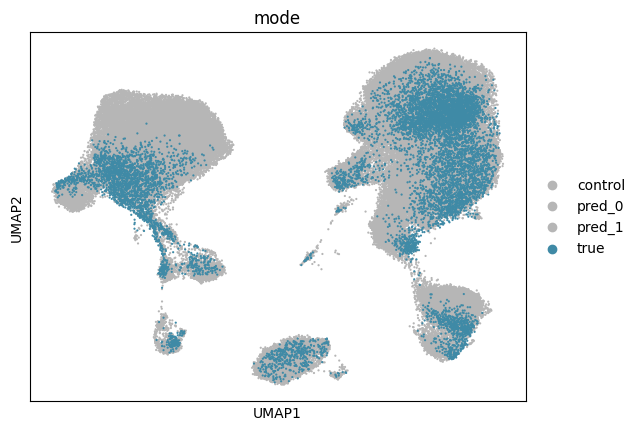

In [25]:
palette = {"control": "#B6B6B6", "true": "#3F8AA6", "pred_0": "#B6B6B6", "pred_1": "#B6B6B6", "pred_11": "#B6B6B6"}
order =  list(bdata[bdata.obs["mode"]=="control"].obs_names) + list(bdata[bdata.obs["mode"]=="pred_0"].obs_names) + list(bdata[bdata.obs["mode"]=="pred_1"].obs_names) + list(bdata[bdata.obs["mode"]=="true"].obs_names) 
fig = sc.pl.umap(bdata[order], color="mode", size=10, palette=palette, return_fig=True)
fig.savefig(os.path.join(out_dir, "all_true.png"), dpi=300)

/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/anndata/_core/anndata.py:1209: Imp

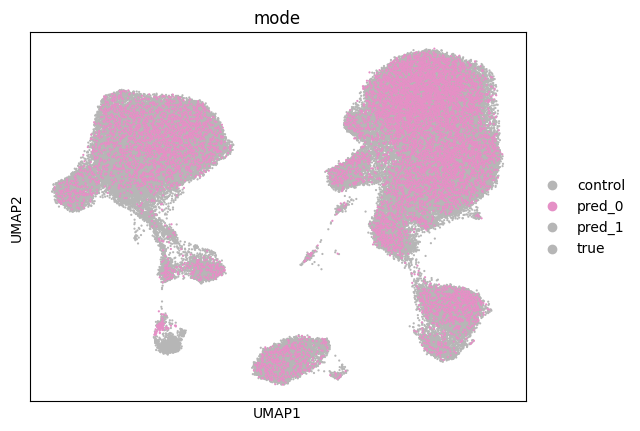

In [26]:
palette = {"pred_0": "#E590C6", "pred_1": "#B6B6B6", "pred_11": "#B6B6B6", "true": "#B6B6B6", "control": "#B6B6B6"}
order =  list(bdata[bdata.obs["mode"]=="control"].obs_names)  + list(bdata[bdata.obs["mode"]=="pred_1"].obs_names) + list(bdata[bdata.obs["mode"]=="true"].obs_names) + list(bdata[bdata.obs["mode"]=="pred_0"].obs_names)
fig = sc.pl.umap(bdata[order], color="mode", size=10, palette=palette, return_fig=True)
fig.savefig(os.path.join(out_dir, "all_pred0.png"), dpi=300)

/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/anndata/_core/anndata.py:1209: Imp

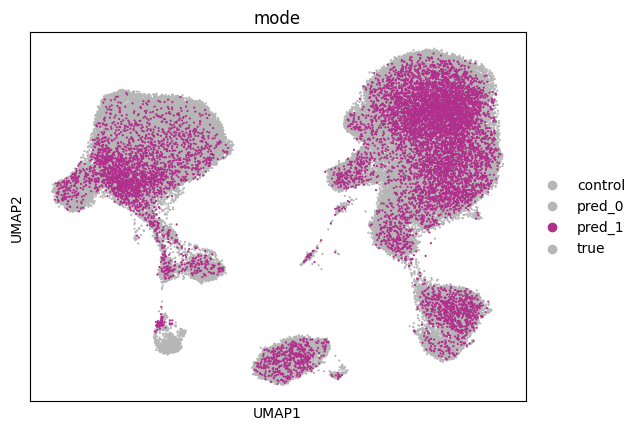

In [27]:
palette = {"pred_1": "#B12F8C", "pred_0": "#B6B6B6", "pred_11": "#B6B6B6", "true": "#B6B6B6", "control": "#B6B6B6"}
order =  list(bdata[bdata.obs["mode"]=="control"].obs_names)  + list(bdata[bdata.obs["mode"]=="pred_0"].obs_names) + list(bdata[bdata.obs["mode"]=="true"].obs_names) + list(bdata[bdata.obs["mode"]=="pred_1"].obs_names)
fig = sc.pl.umap(bdata[order], color="mode", size=10, palette=palette, return_fig=True)
fig.savefig(os.path.join(out_dir, "all_pred1.png"), dpi=300)

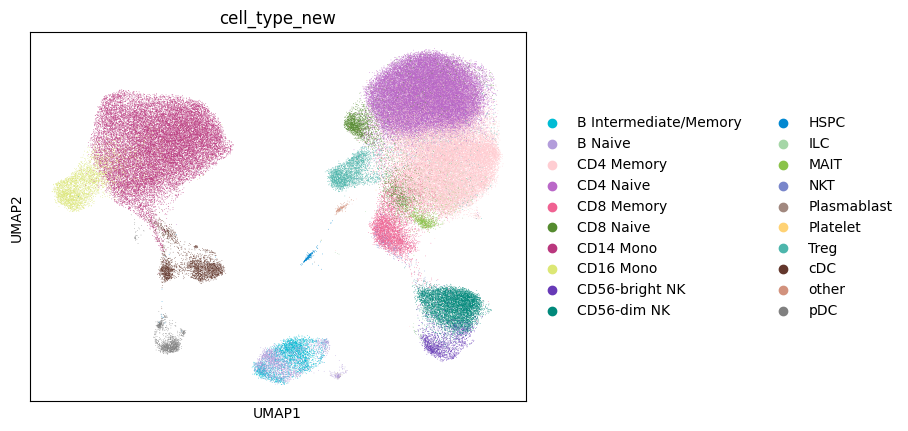

In [28]:
region_colors = {
    "Cortex":"#F06292",
    "Forebrain":"#BA68C8",
    "Hippocampus":"#FFCDD2",
    "Subcortex":"#B39DDB",
    "Striatum":"#BA377E",
    "Hypothalamus":"#673AB7",
    "Thalamus":"#0288D1",
    "Diencephalon":"#7986CB",
    "Midbrain":"#00BCD4", 
    "Midbrain ventral":"#4DB6AC", 
    "Midbrain dorsal":"#00897B", 
    "Hindbrain":"#A5D6A7", 
    "Cerebellum":"#558B2F",
    "Pons":"#8BC34A",
    "Medulla":"#DCE775",
    "Spinal cord":"#63372C", 
    "Other":"grey",
    "ENS":"#a1887f", 
    "SYM":"#D2927D",
    "null": "#FFD274",
}
colors=list(region_colors.values())
ct_palette= {ct: colors[i] for i,ct in enumerate(bdata.obs["cell_type_new"].unique())}
fig = sc.pl.umap(bdata, color="cell_type_new",palette=ct_palette,return_fig=True)
fig.savefig(os.path.join(out_dir, "all_cell_types.png"), dpi=300)

In [29]:
cdata = bdata[bdata.obs["cell_type_new"]=="CD14 Mono"].copy()

/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/scanpy/plotting/_utils.py:471: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


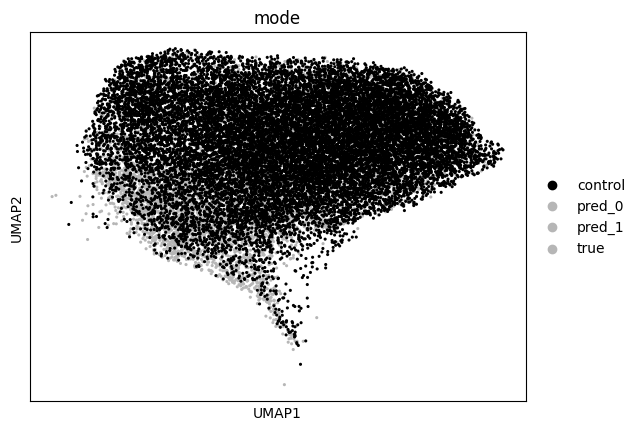

In [30]:
palette = {"control": "#000000", "true": "#B6B6B6", "pred_0": "#B6B6B6", "pred_1": "#B6B6B6", "pred_11": "#B6B6B6"}
order =  list(cdata[cdata.obs["mode"]=="pred_0"].obs_names) + list(cdata[cdata.obs["mode"]=="pred_1"].obs_names) + list(cdata[cdata.obs["mode"]=="true"].obs_names) + list(cdata[cdata.obs["mode"]=="control"].obs_names)  
n_cells_to_highlight = cdata[cdata.obs["mode"]=="control"].n_obs
sizes = [20] * (cdata.n_obs-n_cells_to_highlight) + [20] * n_cells_to_highlight
fig = sc.pl.umap(cdata[order], color="mode", size=sizes, palette=palette, return_fig=True)
fig.savefig(os.path.join(out_dir, "CD14_control.png"), dpi=300)

/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/scanpy/plotting/_utils.py:471: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


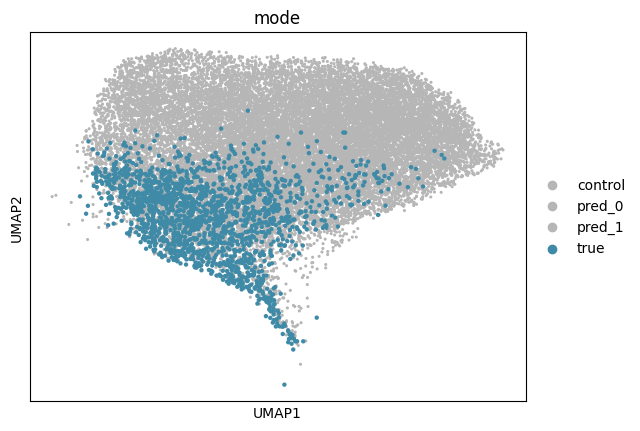

In [31]:
palette = {"control": "#B6B6B6", "true": "#3F8AA6", "pred_0": "#B6B6B6", "pred_1": "#B6B6B6", "pred_11": "#B6B6B6"}
order =  list(cdata[cdata.obs["mode"]=="control"].obs_names) + list(cdata[cdata.obs["mode"]=="pred_0"].obs_names) + list(cdata[cdata.obs["mode"]=="pred_1"].obs_names) + list(cdata[cdata.obs["mode"]=="true"].obs_names) 
n_cells_to_highlight = cdata[cdata.obs["mode"]=="true"].n_obs
sizes = [20] * (cdata.n_obs-n_cells_to_highlight) + [40] * n_cells_to_highlight
fig = sc.pl.umap(cdata[order], color="mode", size=sizes, palette=palette, return_fig=True)
fig.savefig(os.path.join(out_dir, "CD14_true.png"), dpi=300)

/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/scanpy/plotting/_utils.py:471: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


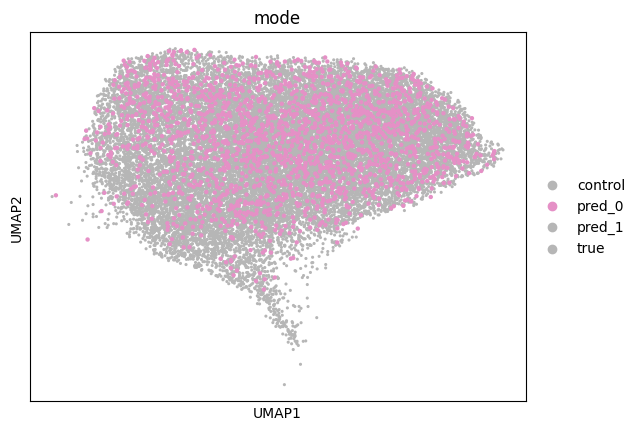

In [32]:
palette = {"control": "#B6B6B6", "true": "#B6B6B6", "pred_0":"#E590C6", "pred_1": "#B6B6B6", "pred_11": "#B6B6B6"}
order =  list(cdata[cdata.obs["mode"]=="control"].obs_names)  + list(cdata[cdata.obs["mode"]=="pred_1"].obs_names)  + list(cdata[cdata.obs["mode"]=="true"].obs_names)+ list(cdata[cdata.obs["mode"]=="pred_0"].obs_names) 
n_cells_to_highlight = cdata[cdata.obs["mode"]=="pred_0"].n_obs
sizes = [20] * (cdata.n_obs-n_cells_to_highlight) + [40] * n_cells_to_highlight
fig = sc.pl.umap(cdata[order], color="mode", size=sizes, palette=palette, return_fig=True)
fig.savefig(os.path.join(out_dir, "CD14_pred_0.png"), dpi=300)


/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/scanpy/plotting/_utils.py:471: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


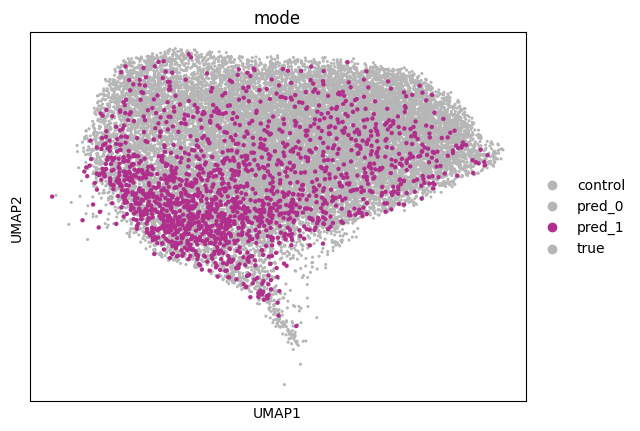

In [33]:
palette = {"control": "#B6B6B6", "true": "#B6B6B6", "pred_0":"#B6B6B6", "pred_1": "#B12F8C", "pred_11": "#B6B6B6"}
order = list(cdata[cdata.obs["mode"]=="control"].obs_names)  + list(cdata[cdata.obs["mode"]=="true"].obs_names)+ list(cdata[cdata.obs["mode"]=="pred_0"].obs_names) + list(cdata[cdata.obs["mode"]=="pred_1"].obs_names) 
n_cells_to_highlight = cdata[cdata.obs["mode"]=="pred_1"].n_obs
sizes = [20] * (cdata.n_obs-n_cells_to_highlight) + [40] * n_cells_to_highlight
fig = sc.pl.umap(cdata[order], color="mode", size=sizes, palette=palette, return_fig=True)
fig.savefig(os.path.join(out_dir, "CD14_pred_1.png"), dpi=300)

In [34]:
with open("/lustre/groups/ml01/workspace/ot_perturbation/data/pbmc/degs.pkl", "rb") as pickle_file:
    deg_genes = pickle.load(pickle_file)
degs = deg_genes["Donor1_CD14 Mono_IL-15"]

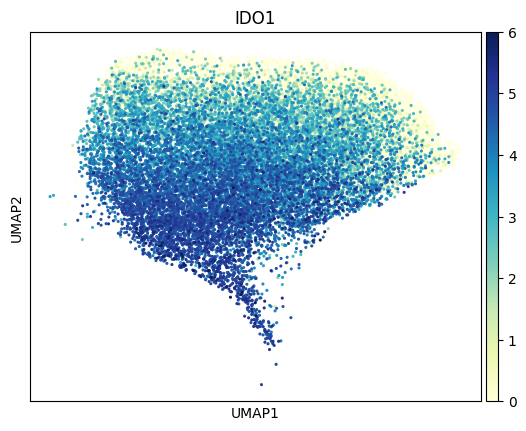

In [35]:
fig=sc.pl.umap(cdata, color=degs[0], size=20, vmin=0, vmax=6.0, return_fig=True, cmap="YlGnBu")
fig.savefig(os.path.join(out_dir, f"CD14_{degs[0]}.png"), dpi=300)

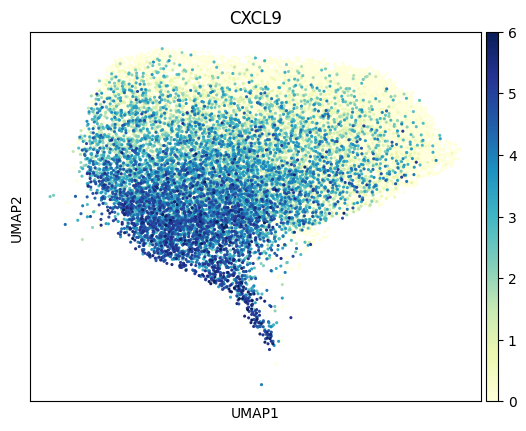

In [36]:
fig=sc.pl.umap(cdata, color=degs[1], size=20, vmin=0, vmax=6.0, return_fig=True, cmap="YlGnBu")
fig.savefig(os.path.join(out_dir, f"CD14_{degs[1]}.png"), dpi=300)

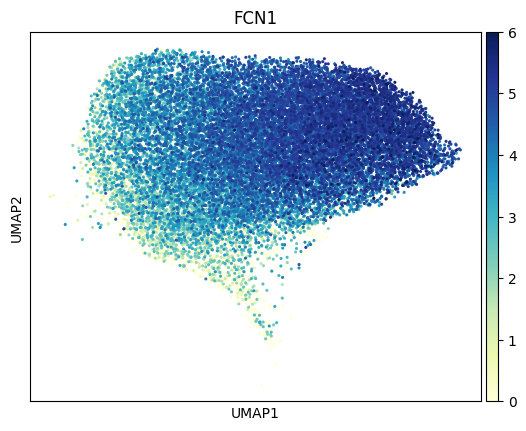

In [37]:
fig=sc.pl.umap(cdata, color=degs[2], size=20, vmin=0, vmax=6.0, return_fig=True, cmap="YlGnBu")
fig.savefig(os.path.join(out_dir, f"CD14_{degs[2]}.png"), dpi=300)

In [38]:
cdata.obs[f"CD14_{degs[0]}"] = np.multiply((cdata.obs["mode"]=="control").values, cdata[:,cdata.var_names==degs[0]].X.toarray().squeeze())

In [39]:
mode = "control"
cdata.obs[f"CD14_{mode}_{degs[0]}"] = cdata[:, degs[0]].X.toarray().flatten()
cdata.obs[f"CD14_{mode}_{degs[0]}"] = cdata.obs.apply(lambda x: x[f"CD14_{mode}_{degs[0]}"] if x["mode"]==mode else None,axis=1)

cdata.obs[f"CD14_{mode}_{degs[1]}"] = cdata[:, degs[1]].X.toarray().flatten()
cdata.obs[f"CD14_{mode}_{degs[1]}"] = cdata.obs.apply(lambda x: x[f"CD14_{mode}_{degs[1]}"] if x["mode"]==mode else None,axis=1)

cdata.obs[f"CD14_{mode}_{degs[2]}"] = cdata[:, degs[2]].X.toarray().flatten()
cdata.obs[f"CD14_{mode}_{degs[2]}"] = cdata.obs.apply(lambda x: x[f"CD14_{mode}_{degs[2]}"] if x["mode"]==mode else None,axis=1)

In [40]:
mode = "pred_0"
cdata.obs[f"CD14_{mode}_{degs[0]}"] = cdata[:, degs[0]].X.toarray().flatten()
cdata.obs[f"CD14_{mode}_{degs[0]}"] = cdata.obs.apply(lambda x: x[f"CD14_{mode}_{degs[0]}"] if x["mode"]==mode else None,axis=1)

cdata.obs[f"CD14_{mode}_{degs[1]}"] = cdata[:, degs[1]].X.toarray().flatten()
cdata.obs[f"CD14_{mode}_{degs[1]}"] = cdata.obs.apply(lambda x: x[f"CD14_{mode}_{degs[1]}"] if x["mode"]==mode else None,axis=1)

cdata.obs[f"CD14_{mode}_{degs[2]}"] = cdata[:, degs[2]].X.toarray().flatten()
cdata.obs[f"CD14_{mode}_{degs[2]}"] = cdata.obs.apply(lambda x: x[f"CD14_{mode}_{degs[2]}"] if x["mode"]==mode else None,axis=1)

In [41]:
mode = "pred_1"
cdata.obs[f"CD14_{mode}_{degs[0]}"] = cdata[:, degs[0]].X.toarray().flatten()
cdata.obs[f"CD14_{mode}_{degs[0]}"] = cdata.obs.apply(lambda x: x[f"CD14_{mode}_{degs[0]}"] if x["mode"]==mode else None,axis=1)

cdata.obs[f"CD14_{mode}_{degs[1]}"] = cdata[:, degs[1]].X.toarray().flatten()
cdata.obs[f"CD14_{mode}_{degs[1]}"] = cdata.obs.apply(lambda x: x[f"CD14_{mode}_{degs[1]}"] if x["mode"]==mode else None,axis=1)

cdata.obs[f"CD14_{mode}_{degs[2]}"] = cdata[:, degs[2]].X.toarray().flatten()
cdata.obs[f"CD14_{mode}_{degs[2]}"] = cdata.obs.apply(lambda x: x[f"CD14_{mode}_{degs[2]}"] if x["mode"]==mode else None,axis=1)

In [42]:
mode = "true"
cdata.obs[f"CD14_{mode}_{degs[0]}"] = cdata[:, degs[0]].X.toarray().flatten()
cdata.obs[f"CD14_{mode}_{degs[0]}"] = cdata.obs.apply(lambda x: x[f"CD14_{mode}_{degs[0]}"] if x["mode"]==mode else None,axis=1)

cdata.obs[f"CD14_{mode}_{degs[1]}"] = cdata[:, degs[1]].X.toarray().flatten()
cdata.obs[f"CD14_{mode}_{degs[1]}"] = cdata.obs.apply(lambda x: x[f"CD14_{mode}_{degs[1]}"] if x["mode"]==mode else None,axis=1)

cdata.obs[f"CD14_{mode}_{degs[2]}"] = cdata[:, degs[2]].X.toarray().flatten()
cdata.obs[f"CD14_{mode}_{degs[2]}"] = cdata.obs.apply(lambda x: x[f"CD14_{mode}_{degs[2]}"] if x["mode"]==mode else None,axis=1)

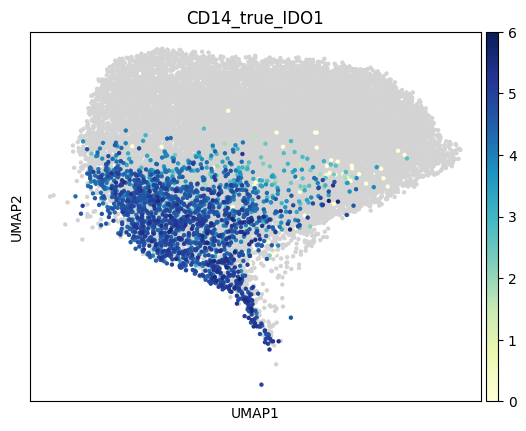

In [43]:
mode= "true"
deg_idx=0
size = [20 if cdata.obs[f"CD14_{mode}_{degs[deg_idx]}"] is None else 40]
fig=sc.pl.umap(cdata, color=f"CD14_{mode}_{degs[deg_idx]}", size=size, vmin=0, vmax=6.0, return_fig=True, cmap="YlGnBu")
fig.savefig(os.path.join(out_dir, f"CD14_{mode}_{degs[deg_idx]}.png"), dpi=300)

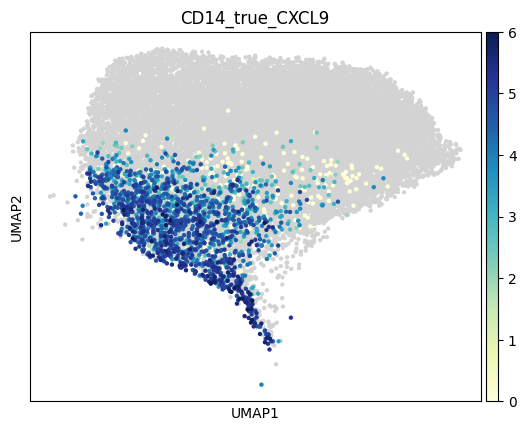

In [44]:
mode= "true"
deg_idx=1
size = [20 if cdata.obs[f"CD14_{mode}_{degs[deg_idx]}"] is None else 40]
fig=sc.pl.umap(cdata, color=f"CD14_{mode}_{degs[deg_idx]}", size=size, vmin=0, vmax=6.0, return_fig=True, cmap="YlGnBu")
fig.savefig(os.path.join(out_dir, f"CD14_{mode}_{degs[deg_idx]}.png"), dpi=300)

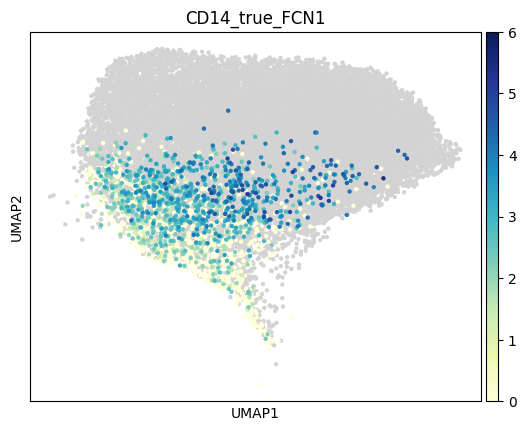

In [45]:
mode= "true"
deg_idx=2
size = [20 if cdata.obs[f"CD14_{mode}_{degs[deg_idx]}"] is None else 40]
fig=sc.pl.umap(cdata, color=f"CD14_{mode}_{degs[deg_idx]}", size=size, vmin=0, vmax=6.0, return_fig=True, cmap="YlGnBu")
fig.savefig(os.path.join(out_dir, f"CD14_{mode}_{degs[deg_idx]}.png"), dpi=300)

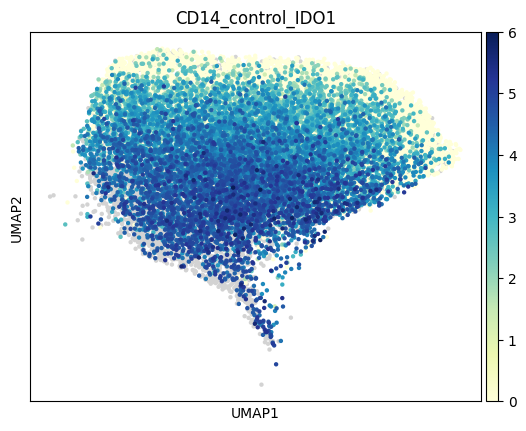

In [46]:
mode= "control"
deg_idx=0
size = [20 if cdata.obs[f"CD14_{mode}_{degs[deg_idx]}"] is None else 40]
fig=sc.pl.umap(cdata, color=f"CD14_{mode}_{degs[deg_idx]}", size=size, vmin=0, vmax=6.0, return_fig=True, cmap="YlGnBu")
fig.savefig(os.path.join(out_dir, f"CD14_{mode}_{degs[deg_idx]}.png"), dpi=300)

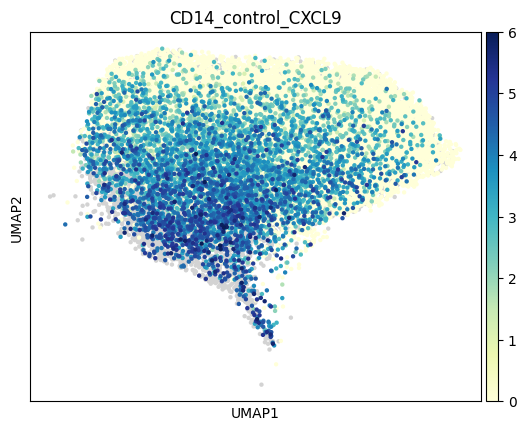

In [47]:
mode= "control"
deg_idx=1
size = [20 if cdata.obs[f"CD14_{mode}_{degs[deg_idx]}"] is None else 40]
fig=sc.pl.umap(cdata, color=f"CD14_{mode}_{degs[deg_idx]}", size=size, vmin=0, vmax=6.0, return_fig=True, cmap="YlGnBu")
fig.savefig(os.path.join(out_dir, f"CD14_{mode}_{degs[deg_idx]}.png"), dpi=300)

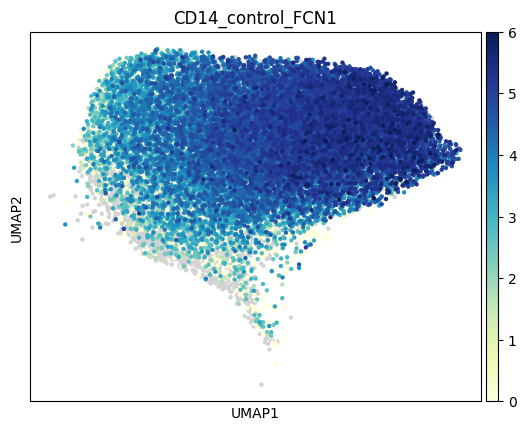

In [48]:
mode= "control"
deg_idx=2
size = [20 if cdata.obs[f"CD14_{mode}_{degs[deg_idx]}"] is None else 40]
fig=sc.pl.umap(cdata, color=f"CD14_{mode}_{degs[deg_idx]}", size=size, vmin=0, vmax=6.0, return_fig=True, cmap="YlGnBu")
fig.savefig(os.path.join(out_dir, f"CD14_{mode}_{degs[deg_idx]}.png"), dpi=300)

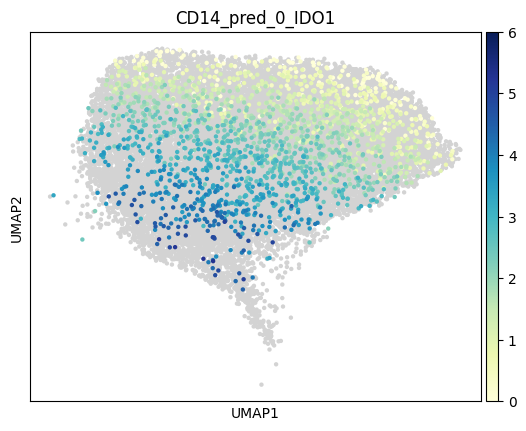

In [49]:
mode= "pred_0"
deg_idx=0
size = [20 if cdata.obs[f"CD14_{mode}_{degs[deg_idx]}"] is None else 40]
fig=sc.pl.umap(cdata, color=f"CD14_{mode}_{degs[deg_idx]}", size=size, vmin=0, vmax=6.0, return_fig=True, cmap="YlGnBu")
fig.savefig(os.path.join(out_dir, f"CD14_{mode}_{degs[deg_idx]}.png"), dpi=300)

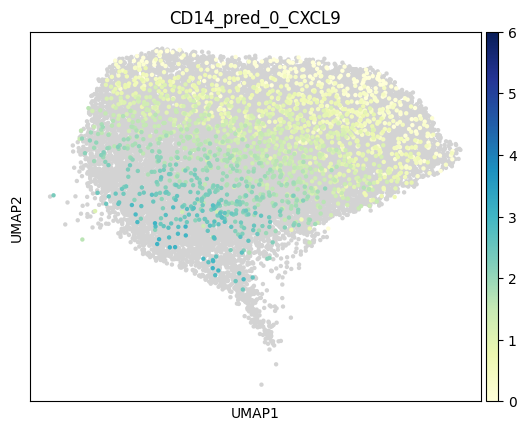

In [50]:
mode= "pred_0"
deg_idx=1
size = [20 if cdata.obs[f"CD14_{mode}_{degs[deg_idx]}"] is None else 40]
fig=sc.pl.umap(cdata, color=f"CD14_{mode}_{degs[deg_idx]}", size=size, vmin=0, vmax=6.0, return_fig=True, cmap="YlGnBu")
fig.savefig(os.path.join(out_dir, f"CD14_{mode}_{degs[deg_idx]}.png"), dpi=300)

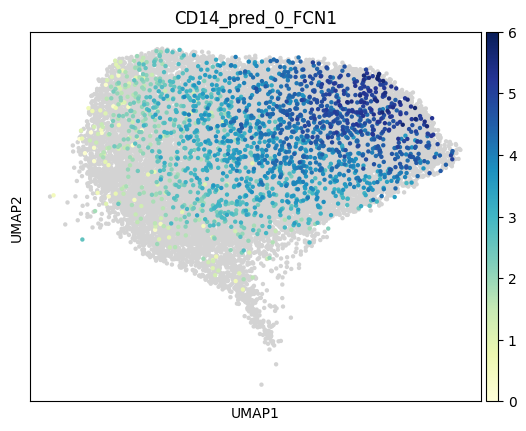

In [51]:
mode= "pred_0"
deg_idx=2
size = [20 if cdata.obs[f"CD14_{mode}_{degs[deg_idx]}"] is None else 40]
fig=sc.pl.umap(cdata, color=f"CD14_{mode}_{degs[deg_idx]}", size=size, vmin=0, vmax=6.0, return_fig=True, cmap="YlGnBu")
fig.savefig(os.path.join(out_dir, f"CD14_{mode}_{degs[deg_idx]}.png"), dpi=300)

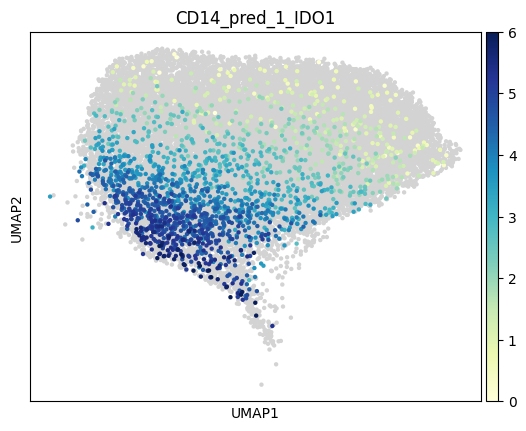

In [52]:
mode= "pred_1"
deg_idx=0
size = [20 if cdata.obs[f"CD14_{mode}_{degs[deg_idx]}"] is None else 40]
fig=sc.pl.umap(cdata, color=f"CD14_{mode}_{degs[deg_idx]}", size=size, vmin=0, vmax=6.0, return_fig=True, cmap="YlGnBu")
fig.savefig(os.path.join(out_dir, f"CD14_{mode}_{degs[deg_idx]}.png"), dpi=300)

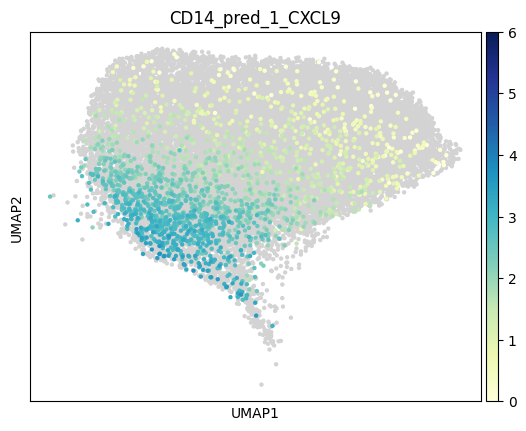

In [53]:
mode= "pred_1"
deg_idx=1
size = [20 if cdata.obs[f"CD14_{mode}_{degs[deg_idx]}"] is None else 40]
fig=sc.pl.umap(cdata, color=f"CD14_{mode}_{degs[deg_idx]}", size=size, vmin=0, vmax=6.0, return_fig=True, cmap="YlGnBu")
fig.savefig(os.path.join(out_dir, f"CD14_{mode}_{degs[deg_idx]}.png"), dpi=300)

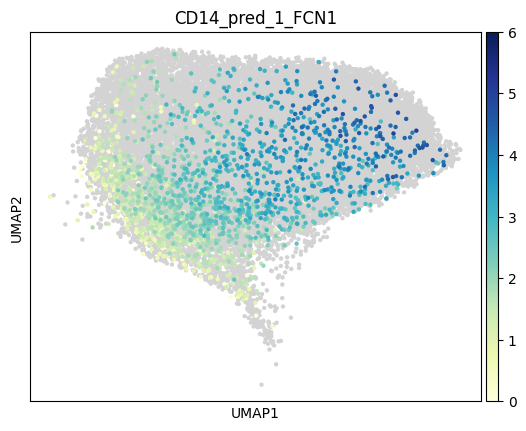

In [54]:
mode= "pred_1"
deg_idx=2
size = [20 if cdata.obs[f"CD14_{mode}_{degs[deg_idx]}"] is None else 40]
fig=sc.pl.umap(cdata, color=f"CD14_{mode}_{degs[deg_idx]}", size=size, vmin=0, vmax=6.0, return_fig=True, cmap="YlGnBu")
fig.savefig(os.path.join(out_dir, f"CD14_{mode}_{degs[deg_idx]}.png"), dpi=300)

In [55]:
df=pd.read_csv("/lustre/groups/ml01/workspace/ot_perturbation/data/pbmc/results/allocation/metrics_new_cytokine.csv", index_col=0)

/tmp/ipykernel_458782/3893254356.py:1: DtypeWarning: Columns (1,128,129,171) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv("/lustre/groups/ml01/workspace/ot_perturbation/data/pbmc/results/allocation/metrics_new_cytokine.csv", index_col=0)


In [56]:
df2 = df[(df["donor"]=="Donor1")&(df["cytokine"]=="IL-15")]

In [57]:
df_id = df2[df2["method"]=="id"].iloc[[0]]

In [58]:
df_cf0 = df2[(df2["method"]=="cf")&(df2["num_donors_in_train"]==0)]

In [59]:
df_cf1 = df2[(df2["method"]=="cf")&(df2["num_donors_in_train"]==1)].iloc[[0]]

In [60]:
df_id["method2"] = "id"
df_cf0["method2"] = "cf0"
df_cf1["method2"] = "cf1"
df_sub = pd.concat((df_id, df_cf0, df_cf1))

/tmp/ipykernel_458782/3796871980.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cf0["method2"] = "cf0"


In [61]:
df_sub["e_distance_CD14_Mono"]=df_sub["e_distance_CD14 Mono"]
df_sub["deg_decoded_r_squared_CD14_Mono"]= df_sub["deg_decoded_r_squared_CD14 Mono"]

In [62]:
df_sub.to_csv("/lustre/groups/ml01/workspace/ot_perturbation/data/pbmc/results/allocation/metrics_sub.csv")

<Axes: xlabel='method2', ylabel='e_distance_CD14 Mono'>

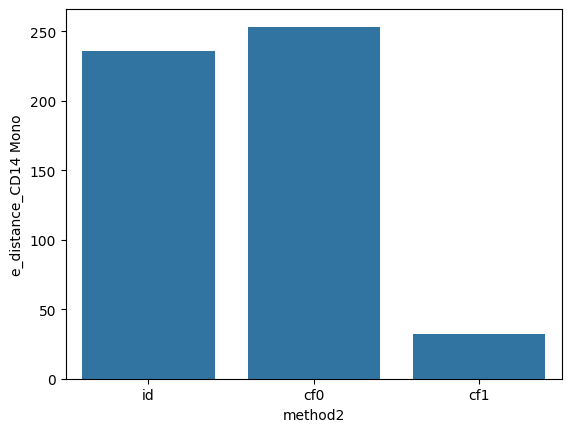

In [63]:
import seaborn as sns
sns.barplot(df_sub, x="method2" ,y="e_distance_CD14 Mono")

<Axes: xlabel='method2', ylabel='ood_e_distance'>

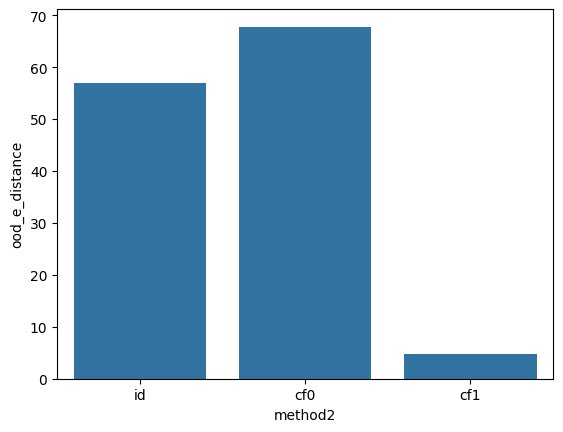

In [64]:
sns.barplot(df_sub, x="method2" ,y="ood_e_distance")

In [65]:
list(df_sub.columns)

['Unnamed: 0',
 'mean_decoded_r_sq_per_cell_type',
 'mean_e_distance_per_cell_type',
 'mean_mmd_per_cell_type',
 'mean_sdiv_10_per_cell_type',
 'mean_sdiv_100_per_cell_type',
 'mean_deg_r_sq_per_cell_type',
 'mean_deg_e_distance_per_cell_type',
 'mean_deg_mmd_per_cell_type',
 'mean_deg_sdiv_10_per_cell_type',
 'mean_deg_sdiv_100_per_cell_type',
 'decoded_r_squared_B Naive',
 'decoded_r_squared_CD4 Memory',
 'decoded_r_squared_CD14 Mono',
 'decoded_r_squared_CD16 Mono',
 'decoded_r_squared_CD8 Memory',
 'decoded_r_squared_CD56-bright NK',
 'decoded_r_squared_CD4 Naive',
 'decoded_r_squared_CD8 Naive',
 'decoded_r_squared_B Intermediate/Memory',
 'decoded_r_squared_CD56-dim NK',
 'decoded_r_squared_cDC',
 'e_distance_B Naive',
 'e_distance_CD4 Memory',
 'e_distance_CD14 Mono',
 'e_distance_CD16 Mono',
 'e_distance_CD8 Memory',
 'e_distance_CD56-bright NK',
 'e_distance_CD4 Naive',
 'e_distance_CD8 Naive',
 'e_distance_B Intermediate/Memory',
 'e_distance_CD56-dim NK',
 'e_distance_cDC',


In [66]:
ct_palette

{'CD8 Memory': '#F06292',
 'CD4 Naive': '#BA68C8',
 'CD4 Memory': '#FFCDD2',
 'B Naive': '#B39DDB',
 'CD14 Mono': '#BA377E',
 'CD56-bright NK': '#673AB7',
 'HSPC': '#0288D1',
 'NKT': '#7986CB',
 'B Intermediate/Memory': '#00BCD4',
 'Treg': '#4DB6AC',
 'CD56-dim NK': '#00897B',
 'ILC': '#A5D6A7',
 'CD8 Naive': '#558B2F',
 'MAIT': '#8BC34A',
 'CD16 Mono': '#DCE775',
 'cDC': '#63372C',
 'pDC': 'grey',
 'Plasmablast': '#a1887f',
 'other': '#D2927D',
 'Platelet': '#FFD274'}